In [114]:
import camelot
import pandas as pd
import numpy as np

In [359]:
## Read in all table regions
filepath = './stations/ktvk.pdf'
p1t = camelot.read_pdf(filepath, 
                     strip_text=' .\n', flavor='stream', pages="1",
                     table_regions=['0,285,600,0'], split_text=True)
p2t = camelot.read_pdf(filepath, 
                     strip_text=' .\n', flavor='stream', pages="2-end",
                      table_regions=['0,700,600,0'])


In [368]:
## Put all scraped tables into one array to iterate through.
pdf = [p1t[0].df]
for t in p2t:
    pdf.append(t.df)

try:
    ads = processTables(pdf)
except KeyError:
    print('yo')

yo


In [362]:
def processTables(tables):
    ## Create the ad day/times df.
    ads = pd.DataFrame(columns=['StartDate', 'EndDate', 'Weekdays', 'Spots/Week', 'Rate', 'Rating', 'index'])
    ## Create the shows DF.
    shows = pd.DataFrame(columns=np.append(tables[0].loc[0, :].values, 'index'))
    shows = shows.loc[:, 'Start':]
    shows = shows.loc[:,~shows.columns.duplicated()]
    ## Create final adtimes DF.
    adtimes = pd.DataFrame(columns=['Date', 'Rate', 'Committee', 'Station', 'Program'])
    ## Add second line of inventory code
    def addNameIfDiff(p):
        if(p['InventoryCode'] != nlines['InventoryCode'][p.name]):
            p['InventoryCode'] = nlines['InventoryCode'][p.name] + p['InventoryCode']
        return p
    ## Merge program names into ad days.
    def mergeProgs(i):
        p = shows[shows['index']<=i]
        p = p.iloc[len(p)-1]
        return p['InventoryCode']
    ## Create individual records for each ad spot.  
    def expandDays(x):
        global adtimes
        adStartDate = datetime.strptime(x['StartDate'], '%m/%d/%y')
        for i, day in enumerate(x['Weekdays']):
            if(day!='-'):
                if(day.isdigit()):
                    for j in range(0, int(day)):
                        adtimes = adtimes.append({
                                    'Date': (adStartDate + timedelta(days=i)),  
                                    'Rate': x['Rate'],
                                    'Committee': committee,
                                    'Station': station,
                                    'Program': x['Program']
                                   }, ignore_index=True)
                else: ## CODE FOR MTW
                    pass
    ## Filter out day times rows.                
    def getDays(row):
        dayCols = ['StartDate', 'EndDate', 'Weekdays', 'Spots/Week', 'Rate', 'Rating']
        for val in row:
            try:
                ind = dayCols.index(val)
                dayCols.remove(val)
            except:
                pass
        if(len(dayCols) == 0):
            if(len(headers)==0):
                headers.append(row.name)
            for k in buys.loc[row.name+1, :]:
                if k == 'Week:':
                    headers.append(row.name+1)
    ## Filter out program names.
    lastIndex = 0
    for t in tables:
        ## File out inventory code lines
        progs = t.copy()
        progs.columns = progs.iloc[0]
        progs = progs.loc[1:, 'Start':]
        progs = progs[(progs['Amount'] != '') & (progs['InventoryCode'] != '')]
        progs = progs.reset_index()
        nlines = progs[(progs['Start'] == '') & (progs['InventoryCode'] != '')]
        nlines = nlines.reset_index()
        ## Merge in second lines if the stations forms has them.
        if (len(nlines) != 0):
            if (len(nlines) == len(progs)):
                progs = progs.apply(addNameIfDiff, axis=1)
            else:
                print("Scraping Error")
        ## Make index run continously accross pages.
        progs['index'] = progs['index'] + lastIndex
        lastIndex = progs.loc[len(progs)-1, :]['index'] + 1
        ## Remove duplicate columns and append to the master list.
        progs = progs.loc[:,~progs.columns.duplicated()]
        shows = shows.append(progs)
    ## Seperate out the days and times each ad will be on.
    lastIndex = 0
    for t in tables:
        headers = []
        buys = t.dropna(how='all')
        buys.apply(getDays, axis=1)
        days = buys.iloc[headers]
        days = days.replace('', np.nan)
        days = days.dropna(axis='columns')
        days.columns = days.iloc[0]
        days = days[1:]
        days = days.reset_index()
        days['index'] = days['index'] + lastIndex
        lastIndex = days.loc[len(days)-1, :]['index'] + 1
        ads = ads.append(days)
    ## Add in Program Names
    ads['Program'] = ads['index'].apply(mergeProgs)
    ## Expand each ad buy listing to individual spots
    ads.apply(expandDays, axis=1)
    return adtimes


In [183]:
from datetime import datetime  
from datetime import timedelta  

station = "KNVX"
committee = "Ducey"


days['Program'] = '10-5 News'


,Date,Rate,Station,Program,Committee
0,2018-10-09,$45000,KNVX,10-5 News,Ducey
1,2018-10-11,$45000,KNVX,10-5 News,Ducey
2,2018-10-12,$45000,KNVX,10-5 News,Ducey
3,2018-10-09,$60000,KNVX,10-5 News,Ducey
4,2018-10-11,$60000,KNVX,10-5 News,Ducey
5,2018-10-12,$60000,KNVX,10-5 News,Ducey
6,2018-10-13,$20000,KNVX,10-5 News,Ducey
7,2018-10-14,$20000,KNVX,10-5 News,Ducey


In [345]:
adtimes.head()

,Date,Rate,Committee,Station,Program


In [358]:
p1t[0].df

,0,1,2,3,4,5,6,7,8,9,10
0,,Ln,Ch,StartEnd,InventoryCode,BreakStart/EndTime,DaysLenSpots,,RatePri,Rtg,Type
1,N,1,KTVK,10/29/1811/02/18,M-F4-4:30am,CMM-F4-4:30am,11111--:30,5,$3000PMT,000,NM
2,,,,,M-F4-4:30am,,,,,,
3,,,StartDate,EndDate,Weekdays,Spots/WeekRateRating,,,,,
4,,Week:,10/29/18,11/04/18,11111--,5$3000,000,,,,
5,,Spot,Ch,DateRange,Description,Start/EndTime,Weekdays,Length,Rate,Rtg,Type
6,,,1KTVK,10/29/18-11/04/18,M-F4-4:30am,M-F4-4:30am,MTWThF----,:30,($3000),000,NM
7,,,,SeeMG16,,,,,,,
8,,,,[OSLD-OVERSOLD],,,,,,,
9,,,2KTVK,10/29/18-11/04/18,M-F4-4:30am,M-F4-4:30am,MTWThF----,:30,($3000),000,NM


NameError: name 'plt' is not defined

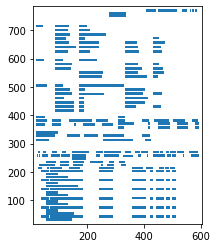

In [371]:
camelot.plot(p1t[0], kind='text')
plt.show()